# A filter for BAGAN_GP

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Dropout,Flatten,Dense,Input
from tensorflow.keras import Model

## Prepare the dataset

In [2]:
## Load raw data

seq_data=[]
label_data=[]
f_s_data=[]
seq_dict={ "T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
# inverse_seq_dict={ 0.25 : 'T', 0.5 : 'C', 0.75 : 'A', 1 : 'G'}
for cls in range(5):
    x_data=pd.read_csv("./seq_{cls}.csv".format(cls=cls+1),header=0)
    for idx,row in x_data.iterrows():
        sub_seq_list=[]
        sub_feature_list=[]
        for i in row[0]:
            sub_seq_list.append(seq_dict[i])
        for j in row[1:]:
            sub_feature_list.append(j)
        f_s_data.append((sub_seq_list,sub_feature_list))
        label_data.append(cls)

In [3]:
##  Proportionally split training data and test data

from sklearn.model_selection import train_test_split
SEED = 15
x_train, x_test, y_train, y_test = train_test_split(f_s_data, label_data,
                                                  random_state=SEED,
                                                  test_size=0.2,
                                                  stratify=label_data)
label_train=y_train
label_test=y_test
y_train=tf.one_hot(y_train, depth=5)
y_test=tf.one_hot(y_test,depth=5)

feature_data=[]
seq_data=[]
for i in x_train:
    feature_data.append(i[1])
    seq_data.append(i[0])
feature_data=np.array(feature_data)
seq_data=np.expand_dims(np.array(seq_data),-1)
x_train=(tf.convert_to_tensor(seq_data, dtype=tf.float32),tf.convert_to_tensor(feature_data, dtype=tf.float32))

feature_data=[]
seq_data=[]
for i in x_test:
    feature_data.append(i[1])
    seq_data.append(i[0])
feature_data=np.array(feature_data)
seq_data=np.expand_dims(np.array(seq_data),-1)
x_test=(tf.convert_to_tensor(seq_data, dtype=tf.float32),tf.convert_to_tensor(feature_data, dtype=tf.float32))

In [4]:
## The proportion of data by category
print("{count}".format(count=np.unique(label_train)))
for i in np.unique(label_train):
    print("{i}:{sum}".format(i=i,sum=np.sum(label_train==i)/len(label_train)))

[0 1 2 3 4]
0:0.5092165898617511
1:0.13895781637717122
2:0.1338177951081177
3:0.08454448777029422
4:0.13346331088266572


In [5]:
print("{count}".format(count=np.unique(label_test)))
for i in np.unique(label_test):
    print("{i}:{sum}".format(i=i,sum=np.sum(label_test==i)/len(label_test)))

[0 1 2 3 4]
0:0.5095676824946846
1:0.13890857547838412
2:0.1339475549255847
3:0.08433734939759036
4:0.1332388377037562


## Define and train the filter model

In [ ]:
class Modforcls(Model):
    def __init__(self):
        super(Modforcls, self).__init__()
        
        self.c1 = Conv2D(128, (3, 3),padding='same',input_shape=(10, 4, 1),kernel_regularizer='l1')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        
        self.c2=Conv2D(128, (3, 3),padding='same', kernel_regularizer='l1')
        self.b2 = BatchNormalization()
        self.a2 = Activation('relu')
        
        self.c3 = Conv2D(64, (3, 3),padding='same', kernel_regularizer='l1')
        self.b3 = BatchNormalization()
        self.a3 = Activation('relu')
        
        self.flatten = Flatten()
        
        self.f1 = Dense(1024, activation='relu')
        self.df1 = Dropout(0.3)
        self.f2 = Dense(512,activation="relu")
        self.df2 = Dropout(0.3)
        
        self.ff1 = Dense(1024, activation='relu')
        self.dff1 = Dropout(0.3)
        self.ff2 = Dense(256, activation="relu")
        self.dff2 = Dropout(0.3)
        
        self.f3 = Dense(512 , activation="relu")
        self.df3 = Dropout(0.3)
        self.f4 = Dense(256,activation="relu")
        self.df4 = Dropout(0.3)
        self.f5 = Dense(5,activation="softmax")
    

    def call(self, x):
        x_1=x[0]
        x_2=x[1]
        x = self.c1(x_1)
        x = self.b1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        
        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        
        x = self.flatten(x)
        x = self.f1(x)
        x = self.df1(x)
        x = self.f2(x)
        x = self.df2(x)
        
        y = self.ff1(x_2)
        y = self.dff1(y)
        y = self.ff2(y)
        y = self.dff2(y)
        
        out=tf.keras.layers.Concatenate(axis=-1)([x,y])
#         out=tf.keras.layers.add([x,y])
#         out = x
        out = self.f3(out)
        out = self.df3(out)
        out = self.f4(out)
        out = self.df4(out)
        out = self.f5(out)
        return out
    
    def model(self):
        x=Input(shape=(10,4,1))
        y=Input(shape=(5,))
        return Model(inputs=[(x,y)],outputs=self.call((x,y)))
    
    def weight_cross_entropy(self, y_true,y_pred):
    # 0.64281: [1.2, 2.2, 2.2, 3, 2.2]
        weight=tf.constant([[1.2, 2.2, 2.5, 3, 2.2]],dtype=tf.float32)
        loss=tf.reduce_sum(-tf.multiply(y_true,weight)*tf.math.log(y_pred+0.0001),axis=1)
        return loss
    
# tbcallback = TensorBoard(log_dir="./model/tensorboard", histogram_freq=1, write_grads=True)
cpktcallback = ModelCheckpoint("./model/cpkt/cls_weight",
                                 monitor="val_categorical_accuracy",
                                 mode='max',
                                 save_weights_only=True,
                                 save_best_only=True, 
                                 verbose=1,
                                 period=1)

model = Modforcls()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
              loss=model.weight_cross_entropy,
              metrics=['categorical_accuracy'])
model.fit(x_train, y_train, 
          batch_size=64, epochs=500, 
          validation_data=(x_test,y_test), 
          validation_freq=1, shuffle=True,
          callbacks=[cpktcallback])

## save the framework of model
model.save("./model/filter_model")

## Validate the filter model with experment result

In [7]:
# Construct the val set
feature_list=[]
seq_list=[]
seq_dict={"T":[1,0,0,0],"C":[0,1,0,0],"A":[0,0,1,0],"G":[0,0,0,1]}
with open("./val_seq_short.txt") as file:
    seq = file.readlines()
    for sub_seq in seq:
        sub_seq_list=[]
        sub_feature_list=[0.,0.,0.,0.,0.]
        for i in sub_seq.split(" ")[1][:-1]:
            sub_seq_list.append(seq_dict[i])
            if i == "G" or i == "C":
                sub_feature_list[0]+=0.1
            if i == "A":
                sub_feature_list[1]+=0.1
            if i == "G":
                sub_feature_list[2]+=0.1
            if i == "T":
                sub_feature_list[3]+=0.1
            if i == "C":
                sub_feature_list[4]+=0.1
        seq_list.append(sub_seq_list)
        feature_list.append(sub_feature_list)
feature_list=np.array(feature_list)
seq_list=np.expand_dims(np.array(seq_list),axis=-1)
x_val=(tf.convert_to_tensor(seq_list, dtype=tf.float32),tf.convert_to_tensor(feature_list, dtype=tf.float32))

In [8]:
## Print the result in pre.txt
model=load_model("./model/filter_model",compile = False)
model.load_weights("./model/cpkt/cls_weight")
with open('./pre.txt','w') as f:
    for i in tf.argmax(model.predict(x_val),axis=1):
        f.write(str(i.numpy())+'\n')

## Print the ROC curve for filter model

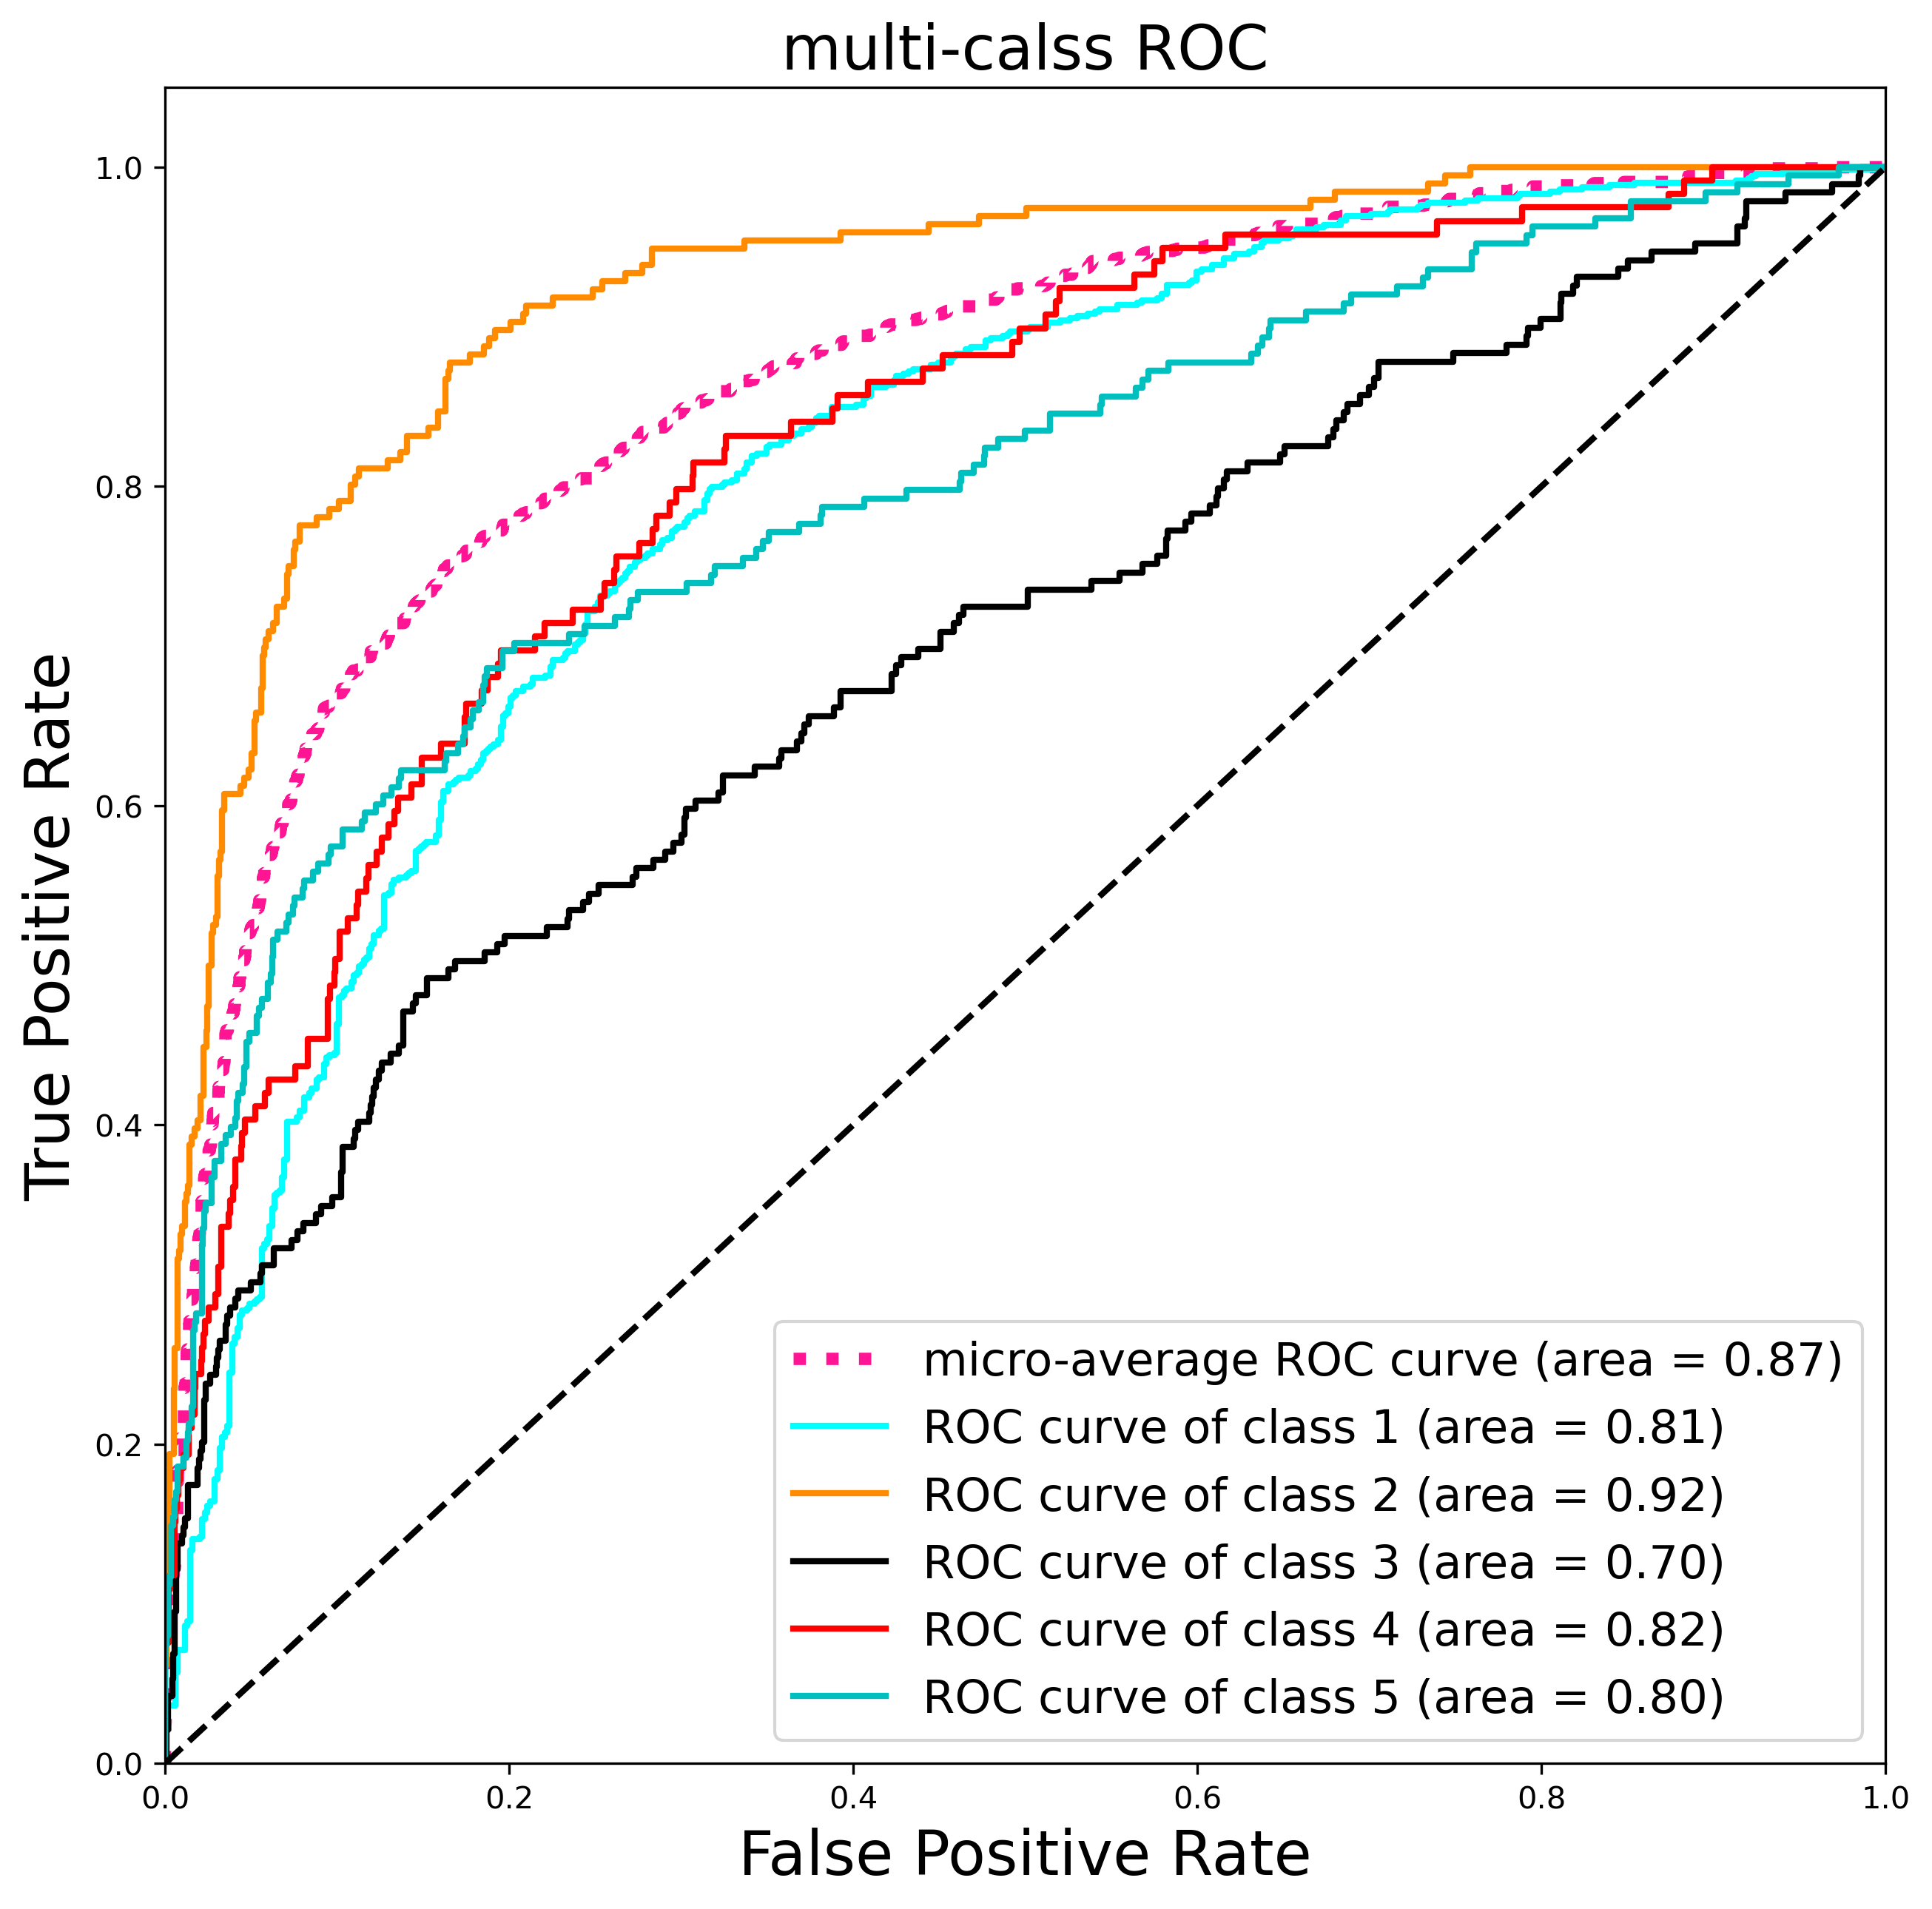

In [10]:
#Print ROC curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
model.load_weights("./model/cpkt/cls_weight")
pre_test=model.predict(x_test)
y_true=y_test.numpy()
y_pre=pre_test
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pre[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pre.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#################################################################################
lw=2
plt.figure(dpi=300, figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'k',  'r', 'c'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('multi-calss ROC',fontsize=20)
plt.legend(loc="lower right",fontsize=15)
plt.savefig("filter_ROC.png",dpi=300,format='png')
plt.show()